# Import bibliotek

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold
import optuna
import typing
import plotly.graph_objs as go
SEED = 2024

# Ładowanie danych

In [2]:
data=pd.read_csv("../data/data_eda.csv")
data=data.drop(columns=['Unnamed: 0'])
features=data.columns.tolist()
features.remove('stars')
target='stars'
data

,pages,stars,reviews,series,mix,character,plot,funny,lighthearted,emotional,...,author_stars,Fiction,Nonfiction,Literary,Fantasy,Crime,Social,Children,Romans,Realism
0,273,4.00,2017,0,0.44,0.51,0.02,0.27,0.37,0.91,...,4.305000,1,1,0,0,0,1,0,1,1
1,302,3.78,7330,0,0.39,0.42,0.17,0.03,0.01,0.18,...,3.670000,1,0,0,0,1,0,0,0,0
2,400,4.15,16761,0,0.51,0.39,0.08,0.02,0.01,0.88,...,0.000000,1,0,1,0,0,0,0,0,0
3,459,4.16,2128,1,0.48,0.10,0.40,0.04,0.02,0.07,...,0.000000,1,0,0,1,0,0,0,0,0
4,160,3.65,6634,1,0.28,0.16,0.54,0.92,0.73,0.00,...,4.115000,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6925,432,4.15,30643,0,0.48,0.05,0.46,0.00,0.00,0.40,...,3.856667,1,0,0,1,1,0,0,0,0
6926,352,3.62,1058,0,0.55,0.13,0.30,0.15,0.10,0.25,...,3.700000,1,0,0,1,0,1,0,0,0
6927,535,3.88,30975,1,0.45,0.08,0.45,0.14,0.19,0.31,...,3.870000,1,0,0,1,0,0,1,0,0
6928,472,3.88,5914,1,0.64,0.12,0.22,0.07,0.00,0.36,...,3.660000,1,0,0,1,0,0,1,0,0


$\text{Podział danych na zbiór treningowy i testowy}$

In [3]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED)

In [4]:
def perform_cv(X: pd.DataFrame, y: pd.Series, algorithm: typing.Any, cv: typing.Any = KFold(n_splits=5, shuffle=True, random_state=SEED), metric: typing.Any = mean_squared_error) -> typing.List[float]:
    """
    Perform cross-validation and return list of scores
    
    Args:
        X (pd.DataFrame): input data
        y (pd.Series): target data
        algorithm (typing.Any): algorithm to use for training and prediction
        cv (typing.Any): cross-validation strategy
        metric (typing.Any): metric to use for evaluation
    
    Returns:
        typing.List[float]: list of scores in order: train_scores, validation_scores
    """
    train_scores = []
    validation_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        algorithm.fit(X_train, y_train)
        y_train_pred = algorithm.predict(X_train)
        y_val_pred = algorithm.predict(X_val)
        train_scores.append(metric(y_train, y_train_pred, squared=False))
        validation_scores.append(metric(y_val, y_val_pred, squared=False))
    return np.mean(train_scores), np.mean(validation_scores)

def test_evaluation(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, algorithm: typing.Any, metric: typing.Any = mean_squared_error) -> float:
    """
    Train the algorithm on the train data and evaluate on the test data
    
    Args:
        X_train (pd.DataFrame): input train data
        y_train (pd.Series): target train data
        X_test (pd.DataFrame): input test data
        y_test (pd.Series): target test data
        algorithm (typing.Any): algorithm to use for training and prediction
        metric (typing.Any): metric to use for evaluation
    
    Returns:
        float: test score
    """
    algorithm.fit(X_train, y_train)
    y_test_pred = algorithm.predict(X_test)
    return metric(y_test, y_test_pred, squared=False)

## Base score

In [5]:
model = DecisionTreeRegressor(random_state=SEED)
train_scores, validation_scores = perform_cv(train_data[features], train_data[target], model)
test_score = test_evaluation(train_data[features], train_data[target], test_data[features], test_data[target], model)
print("Średni błąd RMSE na zbiorze treningowym: {:.5f}".format(train_scores))
print("Średni błąd RMSE na zbiorze walidacyjnym: {:.5f}".format(validation_scores))
print("Błąd RMSE na zbiorze testowym: {:.5f}".format(test_score))

Średni błąd RMSE na zbiorze treningowym: 0.00000
Średni błąd RMSE na zbiorze walidacyjnym: 0.29438
Błąd RMSE na zbiorze testowym: 0.29526


$\text{Bardzo duża dysproporcja między wynikami dla zbioru treningowego a walidacyjnego i testowego}$<p>
$\text{Rezultaty sugerują przetrenowanie modelu.}$<p>
$\text{W kolejnych etapach będziemy dążyć do redukcji overfittingu i polepszenia wyników na zbiorach ewaluacyjnych.}$

# Pre prunning

$\text{Pierwszym z zastosowanych rozwiązań będzie pre prunning.}$<p>
$\text{Proces ten polega na dostosowaniu parametrów modelu tak, aby zminimalizować ryzyko przetrenowania.}$<p>
$\text{W celu znalezienia optymalnych hiperparametrów wykorzystamy walidację krzyżową.}$

## Max depth

$\text{Maksymalna głębokość drzewa odpowiada za to, jak wiele razy model będzie dzielił dane i jak duże drzewo zostanie zbudowane.}$<p>
$\text{Wartość domyślna to None, co oznacza, że drzewo będzie rosnąć aż do momentu, gdy każdy liść będzie "czysty".}$<p>
$\text{Zmniejszenie głębokości drzewa może pomóc w redukcji overfittingu.}$

In [6]:
for max_depth_value in range(2, 22, 2):
    model = DecisionTreeRegressor(max_depth=max_depth_value, random_state=SEED)
    train_scores, validation_scores = perform_cv(train_data[features], train_data[target], model)
    print("Max depth: {}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(max_depth_value, train_scores, validation_scores))

Max depth: 2; RMSE train: 0.25803; RMSE validation: 0.25895
Max depth: 4; RMSE train: 0.23890; RMSE validation: 0.24366
Max depth: 6; RMSE train: 0.21784; RMSE validation: 0.23572
Max depth: 8; RMSE train: 0.19292; RMSE validation: 0.24254
Max depth: 10; RMSE train: 0.16144; RMSE validation: 0.25682
Max depth: 12; RMSE train: 0.12708; RMSE validation: 0.27229
Max depth: 14; RMSE train: 0.09289; RMSE validation: 0.28451
Max depth: 16; RMSE train: 0.06330; RMSE validation: 0.28915
Max depth: 18; RMSE train: 0.04142; RMSE validation: 0.29343
Max depth: 20; RMSE train: 0.02585; RMSE validation: 0.29476


$\text{Wraz ze wzrostem głębokości drzewa, model coraz bardziej dopasowuje się do danych treningowych, a wyniki na zbiorze walidacyjnym pogarszają się.}$<p>
$\text{Rezultaty na zbiorze walidacyjnym w okolicach 4-8 wydają się być najlepsze.}$

In [7]:
for max_depth_value in range(4, 9, 1):
    model = DecisionTreeRegressor(max_depth=max_depth_value, random_state=SEED)
    train_scores, validation_scores = perform_cv(train_data[features], train_data[target], model)
    print("Max depth: {}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(max_depth_value, train_scores, validation_scores))

Max depth: 4; RMSE train: 0.23890; RMSE validation: 0.24366
Max depth: 5; RMSE train: 0.22799; RMSE validation: 0.23743
Max depth: 6; RMSE train: 0.21784; RMSE validation: 0.23572
Max depth: 7; RMSE train: 0.20609; RMSE validation: 0.23761
Max depth: 8; RMSE train: 0.19292; RMSE validation: 0.24254


$\text{Głębokość drzewa 6 wydaje się być optymalna.}$

## Criterion

$\text{Kryterium podziału drzewa w problemach regresji to: squared\_error, friedman\_mse, absolute\_error oraz poisson.}$<p>
$\text{Domyślnie wykorzystywane jest squared\_error, natomiast warto sprawdzić, czy inne kryteria nie przyniosą lepszych wyników.}$

In [8]:
for criterion in ["squared_error", "friedman_mse", "absolute_error", "poisson"]:
    model = DecisionTreeRegressor(criterion=criterion, max_depth=6, random_state=SEED)
    train_scores, validation_scores = perform_cv(train_data[features], train_data[target], model)
    print("Criterion: {}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(criterion, train_scores, validation_scores))

Criterion: squared_error; RMSE train: 0.21784; RMSE validation: 0.23572
Criterion: friedman_mse; RMSE train: 0.21784; RMSE validation: 0.23575
Criterion: absolute_error; RMSE train: 0.22104; RMSE validation: 0.23902
Criterion: poisson; RMSE train: 0.21753; RMSE validation: 0.23563


$\text{Najlepsze wyniki na zbiorach walidacyjnych uzyskano dla absolute\_error.}$<p>
$\text{Warto jednak zaznaczyć, że różnice w wynikach są niewielkie, a strata dla zbioru treningowego jest największa dla tego kryterium.}$<p>
$\text{Ponadto czas inferencji dla tego kryterium jest najdłuższy.}$<p>
$\text{Z tego powodu zdecydowano się na pozostanie przy domyślnym squared\_error.}$

## Min samples split

$\text{Definiuje minimalną liczbę obserwacji, które są wymagane, aby dokonano podziału danego węzła.}$<p>
$\text{Im wyższe wartości min\_samples\_split tym model może dzielić dane na coraz to mniejsze próbki powodując, że drzewo uczy się specyficznych wzorców zwiększając tym samym prawdopodobieństwo wystąpienia overfittingu.}$<p>
$\text{Zbyt wysokie wartości mogą prowadzić natomiast do underfittingu.}$

In [9]:
for min_samples_split_value in range(2, 200, 10):
    model = DecisionTreeRegressor(criterion="squared_error", max_depth=6, min_samples_split=min_samples_split_value, random_state=SEED)
    train_scores, validation_scores = perform_cv(train_data[features], train_data[target], model)
    print("Min samples split: {}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(min_samples_split_value, train_scores, validation_scores))

Min samples split: 2; RMSE train: 0.21784; RMSE validation: 0.23572
Min samples split: 12; RMSE train: 0.21810; RMSE validation: 0.23571
Min samples split: 22; RMSE train: 0.21830; RMSE validation: 0.23549
Min samples split: 32; RMSE train: 0.21897; RMSE validation: 0.23534
Min samples split: 42; RMSE train: 0.21932; RMSE validation: 0.23526
Min samples split: 52; RMSE train: 0.21961; RMSE validation: 0.23490
Min samples split: 62; RMSE train: 0.22012; RMSE validation: 0.23479
Min samples split: 72; RMSE train: 0.22054; RMSE validation: 0.23458
Min samples split: 82; RMSE train: 0.22100; RMSE validation: 0.23468
Min samples split: 92; RMSE train: 0.22133; RMSE validation: 0.23461
Min samples split: 102; RMSE train: 0.22174; RMSE validation: 0.23440
Min samples split: 112; RMSE train: 0.22263; RMSE validation: 0.23463
Min samples split: 122; RMSE train: 0.22282; RMSE validation: 0.23480
Min samples split: 132; RMSE train: 0.22329; RMSE validation: 0.23460
Min samples split: 142; RMSE tr

$\text{Wykorzystany przez nas przedział jest dość szeroki, jednak wygląda na to, że niewielka poprawa rezultatów na zbiorze walidacyjnym następuje do wartości 152, po czym wyniki zaczynają się pogarszać.}$<p>
$\text{Warto również odnotować widoczny wzrost RMSE na zbiorze treningowym wraz ze wzrostem wartości min\_samples\_split.}$<p>
$\text{Spróbujemy znaleźć dokładniejszą, optymalną wartość w okolicach 152.}$

In [10]:
for min_samples_split_value in range(145, 155, 1):
    model = DecisionTreeRegressor(criterion="squared_error", max_depth=6, min_samples_split=min_samples_split_value, random_state=SEED)
    train_scores, validation_scores = perform_cv(train_data[features], train_data[target], model)
    print("Min samples split: {}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(min_samples_split_value, train_scores, validation_scores))

Min samples split: 145; RMSE train: 0.22346; RMSE validation: 0.23465
Min samples split: 146; RMSE train: 0.22346; RMSE validation: 0.23465
Min samples split: 147; RMSE train: 0.22346; RMSE validation: 0.23465
Min samples split: 148; RMSE train: 0.22346; RMSE validation: 0.23465
Min samples split: 149; RMSE train: 0.22346; RMSE validation: 0.23465
Min samples split: 150; RMSE train: 0.22357; RMSE validation: 0.23460
Min samples split: 151; RMSE train: 0.22367; RMSE validation: 0.23453
Min samples split: 152; RMSE train: 0.22367; RMSE validation: 0.23453
Min samples split: 153; RMSE train: 0.22367; RMSE validation: 0.23453
Min samples split: 154; RMSE train: 0.22374; RMSE validation: 0.23454


$\text{Dla wartości min\_samples\_split=149 uzyskano nieznacznie lepsze wyniki na zbiorze walidacyjnym niż w pozoatłych przypadkach.}$

## Max features

$\text{Definiuje liczbę rozpatrywanych zmiennych, które będą brane pod uwagę podczas dokonywania podziału.}$<p>
$\text{Im mniej zmiennych do sprawdzenia tym krótszy czas potrzebny do budowy drzewa, natomiast jednocześnie zwiększa się prawdopodobieństwo, że nie wybierzemy najbardziej optymalnej zmiennej w danym węźle co może zmniejszyć skuteczność}$

In [11]:
for max_features_value in ["sqrt", "log2", None]:
    model = DecisionTreeRegressor(criterion="squared_error", max_depth=6, min_samples_split=149, max_features=max_features_value, random_state=SEED)
    train_scores, validation_scores = perform_cv(train_data[features], train_data[target], model)
    print("Max features: {}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(max_features_value, train_scores, validation_scores))

Max features: sqrt; RMSE train: 0.23937; RMSE validation: 0.24942
Max features: log2; RMSE train: 0.24927; RMSE validation: 0.26053
Max features: None; RMSE train: 0.22346; RMSE validation: 0.23465


$\text{Jak widać, różnice są dosyć znaczące.}$<p>
$\text{W sytuacji, gdybyśmy nie przechodzili przez wszystkie zmienne, wyniki na zbiorach treningowym i walidacyjnym byłyby znacznie gorsze.}$

## Tuning

$\text{Ponieważ sekwencyjne znajdowanie optymalnych parametrów nie zawsze jest skuteczne w związku z pominięciem potencjalnych "interakcji" między parametrami, zdecydowano się na zastosowanie Random Search z biblioteki optuna.}$

In [12]:
class RandomSearchCV:
    """
    This class is used to optimize the hyperparameters of the algorithm using Random Search.
    """

    def __init__(
        self,
        algorithm: typing.Any,
        metric: str,
        cv: typing.Any = KFold(n_splits=5, shuffle=True, random_state=17),
        n_trials: int = 100,
        seed: int = 17,
    ) -> None:
        """
        Initializes the RandomSearchCV class.

        Args:
            algorithm (typing.Any): algorithm to optimize.
            metric (str): metric to use for optimization.
            cv (typing.Any): cross-validation strategy.
            n_trials (int): number of trials to perform.
            seed (int): random seed.
        """
        self.algorithm = algorithm
        metrics = {
            "accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds", "maximize"],
            "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs", "maximize"],
            "mse": [lambda y, y_pred: mean_squared_error(y, y_pred), "preds", "minimize"],
            "rmse": [
                lambda y, y_pred: mean_squared_error(y, y_pred, squared=False),
                "preds", "minimize"
            ],
            "mae": [lambda y, y_pred: mean_absolute_error(y, y_pred), "preds", "minimize"],
        }
        if metric not in metrics:
            raise ValueError("Unsupported metric: {}".format(metric))
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]
        self.direction = metrics[metric][2]
        self.cv = cv
        self.n_trials = n_trials
        self.seed = seed
    
    def check_X(
        self, X: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim == 1:
            X = X[None, :]
        return X

    def check_y(
        self, y: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)

    def tune(
        self,
        X: pd.DataFrame,
        y: pd.Series,
        params_grid: typing.Dict[str, typing.Tuple[str, typing.List[typing.Any]]],
        X_valid: pd.DataFrame = None,
        y_valid: pd.Series = None,
    ) -> typing.Dict[str, typing.Any]:
        """
        This method tunes the algorithm hyperparameters.

        Args:
            X (pd.DataFrame): input data.
            y (pd.Series): target data.
            params_grid (typing.Dict[str, typing.Tuple[str, typing.List[typing.Any]]]): hyperparameters grid.
            X_valid (pd.DataFrame): validation data (default is None).
            y_valid (pd.Series): validation labels (default is None).

        Returns:
            typing.Dict[str, typing.Any]: best hyperparameters.
        """
        self.params_grid = params_grid
        study = self.create_study()
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        if X_valid is not None and y_valid is not None:
            X_valid = self.check_X(X_valid)
            y_valid = self.check_y(y_valid)
            X_valid = self.check_for_object_columns(X_valid)
            study.optimize(
                lambda trial: self.objective(trial, X, y, X_valid, y_valid),
                n_trials=self.n_trials,
            )
        else:
            study.optimize(
                lambda trial: self.objective_cv(trial, X, y),
                n_trials=self.n_trials,
            )
        return study.best_params
    
    def create_study(self,) -> optuna.study.Study:
        """This method creates an optuna study object.

        Returns:
            optuna.study.Study: optuna study object.
        """
        sampler = optuna.samplers.TPESampler(seed=self.seed)
        return optuna.create_study(direction=self.direction, sampler=sampler)
    
    def objective(self, trial: optuna.Trial, X_train: np.ndarray, y_train: np.ndarray, X_valid: np.ndarray, y_valid: np.ndarray) -> float:
        """
        This method defines the objective function for optimization when validation data is provided.

        Args:
            trial (optuna.Trial): trial object.
            X_train (np.ndarray): input data.
            y_train (np.ndarray): target data.
            X_valid (np.ndarray): validation data.
            y_valid (np.ndarray): validation labels.
        
        Returns:
            float: Validation score.
        """
        params = {param_name: self.get_param(trial, param_name, param_values) for param_name, param_values in self.params_grid.items()}
        self.algorithm = self.algorithm.set_params(**params)
        model.fit(X_train, y_train)
        y_valid_pred = model.predict(X_valid)
        return self.eval_metric(y_valid, y_valid_pred)
    
    def objective_cv(self, trial: optuna.Trial, X: np.ndarray, y: np.ndarray) -> float:
        """
        This method defines the objective function for optimization when validation data is not provided.

        Args:
            trial (optuna.Trial): trial object.
            X (np.ndarray): input data.
            y (np.ndarray): target data.
        
        Returns:
            float: Cross-validation score.
        """
        params = {param_name: self.get_param(trial, param_name, param_values) for param_name, param_values in self.params_grid.items()}
        self.algorithm = self.algorithm.set_params(**params)
        return self.perform_cv(X, y)

    
    def get_param(self, trial: optuna.Trial, param_name: str, param_values: typing.Tuple[str, typing.List[typing.Any]]) -> typing.Any:
        """
        This method converts the parameter values to the optuna parameter suggestion.

        Args:
            trial (optuna.Trial): trial object.
            param_name (str): parameter name.
            param_values (typing.Tuple[str, typing.List[typing.Any]]): parameter values.

        Returns:
            typing.Any: parameter suggestion.
        """
        param_type, param_value = param_values
        if param_type == "int":
            return trial.suggest_int(param_name, low=param_value[0], high=param_value[1])
        elif param_type == "float":
            return trial.suggest_float(param_name, low=param_value[0], high=param_value[1])
        elif param_type == "categorical":
            return trial.suggest_categorical(param_name, param_value)
        elif param_type == "constant":
            return trial.suggest_categorical(param_name, [param_value])

    def perform_cv(self, X: np.ndarray, y: np.ndarray) -> float:
        """This method performs cross-validation.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.

        Returns:
            float: cross-validation score.
        """
        valid_scores = []
        for train_idx, valid_idx in self.cv.split(X):
            X_train_cv, X_valid_cv = X[train_idx], X[valid_idx]
            y_train_cv, y_valid_cv = y[train_idx], y[valid_idx]
            self.algorithm.fit(X_train_cv, y_train_cv)
            if self.metric_type == "preds":
                y_valid_pred = self.algorithm.predict(X_valid_cv)
            else:
                y_valid_pred = self.algorithm.predict_proba(X_valid_cv)[:, 1]
            valid_scores.append(self.eval_metric(y_valid_cv, y_valid_pred))
        return np.mean(valid_scores)

In [13]:
params_dict = {
    "max_depth": ["int", [2, 10]],
    "min_samples_split": ["int", [2, 200]],
    "max_features": ["categorical", ["sqrt", "log2", None]],
    "random_state": ["constant", SEED],
}
CV = RandomSearchCV(
    algorithm=DecisionTreeRegressor(random_state=SEED),
    metric="rmse",
    cv=KFold(n_splits=5, shuffle=True, random_state=SEED),
    n_trials=200,
    seed=SEED,
)
best_params = CV.tune(X=train_data[features], y=train_data[target], params_grid=params_dict)

[I 2024-05-11 19:38:52,195] A new study created in memory with name: no-name-fb9c29a8-218f-43a0-a0c4-cb029723c9be
[I 2024-05-11 19:38:52,305] Trial 0 finished with value: 0.23459152384259824 and parameters: {'max_depth': 7, 'min_samples_split': 141, 'max_features': None, 'random_state': 2024}. Best is trial 0 with value: 0.23459152384259824.
[I 2024-05-11 19:38:52,320] Trial 1 finished with value: 0.2797263923712494 and parameters: {'max_depth': 2, 'min_samples_split': 146, 'max_features': 'sqrt', 'random_state': 2024}. Best is trial 0 with value: 0.23459152384259824.
[I 2024-05-11 19:38:52,333] Trial 2 finished with value: 0.2812010436351102 and parameters: {'max_depth': 2, 'min_samples_split': 151, 'max_features': 'log2', 'random_state': 2024}. Best is trial 0 with value: 0.23459152384259824.
[I 2024-05-11 19:38:52,450] Trial 3 finished with value: 0.234160105057178 and parameters: {'max_depth': 7, 'min_samples_split': 91, 'max_features': None, 'random_state': 2024}. Best is trial 3 

In [14]:
model = DecisionTreeRegressor(**best_params)
train_scores, validation_scores = perform_cv(train_data[features], train_data[target], model)
test_score = test_evaluation(train_data[features], train_data[target], test_data[features], test_data[target], model)
print("Średni błąd RMSE na zbiorze treningowym: {:.5f}".format(train_scores))
print("Średni błąd RMSE na zbiorze walidacyjnym: {:.5f}".format(validation_scores))

Średni błąd RMSE na zbiorze treningowym: 0.21819
Średni błąd RMSE na zbiorze walidacyjnym: 0.23323


$\text{Optymalizacja hiperparametrów z wykorzystaniem biblioteki optuna dała nieznaacznie lepsze wyniki na zbiorze walidacyjnym porównując do podejścia "krok po kroku".}$

# Post pruning

$\text{Proces ten polega na budowie drzewa decyzyjnego z maksymalną głębokością, a następnie przycinaniu gałęzi, które nie przynoszą korzyści.}$<p>
$\text{Wzór za pomocą, którego możemy zoptymalizować złożoność drzewa wygląda następująco:}$
$$Tree\ Score=sum(Error)+\alpha\times leaves$$
$\text{Zatem jedynym parametrem, który będziemy dostosowywać jest } \alpha.$<p>
$\text{Im wyższa wartość parametru, tym kara nałożona na liczbę liści jest większa, co prowadzi do mniej złożonego drzewa.}$<p>
$\text{Drzewem o optymalnych rozmiarach będzie takie, dla którego Tree\_Score przyjmuje najmniejszą wartość.}$

In [15]:
def depth_alpha_plot(ccp_alphas: typing.List[float], depths: typing.List[int]) -> None:
    """
    This function plots the tree depth vs ccp_alpha.
    
    Args:
        ccp_alphas (typing.List[float]): list of ccp_alphas.
        depths (typing.List[int]): list of tree depths.
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ccp_alphas, y=depths, mode='lines+markers', line=dict(color="blue")))
    fig.update_layout(template="simple_white", width=800, height=800, title="<b>Depth vs Alpha<b>", title_x=0.5, xaxis_title="Alpha", yaxis_title=f"Depth of tree", font=dict(family="Times New Roman",size=16,color="Black"), showlegend=False)
    fig.show("png")

def nodes_alpha_plot(ccp_alphas: typing.List[float], nodes: typing.List[int]) -> None:
    """
    This function plots the number of nodes vs ccp_alpha.
    
    Args:
        ccp_alphas (typing.List[float]): list of ccp_alphas.
        nodes (typing.List[int]): list of number of nodes.
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ccp_alphas, y=nodes, mode='lines+markers', line=dict(color="blue")))
    fig.update_layout(template="simple_white", width=800, height=800, title="<b>Nodes vs Alpha<b>", title_x=0.5, xaxis_title="Alpha", yaxis_title=f"Number of nodes", font=dict(family="Times New Roman",size=16,color="Black"), showlegend=False)
    fig.show("png")

def scores_alpha_plot(ccp_alphas: typing.List[float], train_scores: typing.List[float], valid_scores: typing.List[float], metric_name: str, direction: str) -> None:
    """
    This function plots the metric vs ccp_alpha.

    Args:
        ccp_alphas (typing.List[float]): list of ccp_alphas.
        train_scores (typing.List[float]): list of train scores.
        valid_scores (typing.List[float]): list of validation scores.
        metric_name (str): name of the metric.
        direction (str): maximize or minimize.
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ccp_alphas, y=train_scores, mode='lines+markers', line=dict(color="orange"), name="Train Scores"))
    fig.add_trace(go.Scatter(x=ccp_alphas, y=valid_scores, mode='lines+markers', line=dict(color="blue"), name="Valid Scores"))
    # index_of_best_valid_score = valid_scores.index(max(valid_scores))
    if direction == "minimize":
        index_of_best_valid_score = valid_scores.index(min(valid_scores))
    else:
        index_of_best_valid_score = valid_scores.index(max(valid_scores))
    fig.add_annotation(x=ccp_alphas[index_of_best_valid_score], y=valid_scores[index_of_best_valid_score], showarrow=True, arrowhead=1, text=f"ccp_alpha={np.round(ccp_alphas[index_of_best_valid_score], 5)}", font=dict(family="Times New Roman",size=12,color="Black"))
    fig.update_layout(template="simple_white", width=800, height=800, title=f"<b>{metric_name} vs alpha<b>", title_x=0.5, xaxis_title="Alpha", yaxis_title=f"{metric_name}", font=dict(family="Times New Roman",size=16,color="Black"), showlegend=True)
    fig.show("png")

In [16]:
class DecisionTreePostPruning:
    def __init__(self, algorithm: typing.Any, metric: str, cv: typing.Any = KFold(n_splits=5, shuffle=True, random_state=17), seed: int = 17):
        """
        This class is used to perform cross-validation for Decision Tree algorithm with post-pruning.
        
        Args:
            algorithm (typing.Any): algorithm instance.
            metric (str): metric to use for evaluation.
            cv (typing.Any): cross-validation strategy.
            seed (int): random seed.
        """
        self.algorithm = algorithm
        metrics = {
            "accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds", "maximize"],
            "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs", "maximize"],
            "mse": [lambda y, y_pred: mean_squared_error(y, y_pred), "preds", "minimize"],
            "rmse": [
                lambda y, y_pred: mean_squared_error(y, y_pred, squared=False),
                "preds", "minimize"
            ],
            "mae": [lambda y, y_pred: mean_absolute_error(y, y_pred), "preds", "minimize"],
        }
        if metric not in metrics:
            raise ValueError('Unsupported metric: {}'.format(metric))
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]
        self.direction = metrics[metric][2]
        self.metric_name = metric
        self.cv = cv
        self.seed = seed
    
    def check_X(
        self, X: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim == 1:
            X = X[None, :]
        return X

    def check_y(
        self, y: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)
    
    def find_alphas(self, X: np.ndarray, y: np.ndarray) -> typing.Tuple[np.ndarray, np.ndarray]:
        """This method finds the alphas for post-pruning.

        Args:
            X (np.ndarray): input data.
            y (np.ndarray): target data.
        
        Returns:
            typing.Tuple[np.ndarray, np.ndarray]: ccp_alphas, impurities.
        """
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        path = self.algorithm.cost_complexity_pruning_path(X, y)
        ccp_alphas, impurities = path.ccp_alphas, path.impurities
        return ccp_alphas[:-5], impurities[:-5]
    
    def compare_depth_and_alpha(self, X: np.ndarray, y: np.ndarray):
        """This method compares the depth of the tree with alpha.

        Args:
            X (np.ndarray): input data.
            y (np.ndarray): target data.
        
        Returns:
            Plot: Depth vs Alpha.
        """
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        ccp_alphas, impurities = self.find_alphas(X=X, y=y)
        ccp_alphas_limited = [np.quantile(ccp_alphas, q) for q in np.linspace(0, 1, 15)]
        depths = []
        for ccp_alpha in ccp_alphas_limited:
            algorithm = self.algorithm.set_params(ccp_alpha=ccp_alpha)
            depths.append(algorithm.fit(X, y).tree_.max_depth)
        depth_alpha_plot(ccp_alphas=ccp_alphas_limited, depths=depths)
    
    def compare_nodes_and_alpha(self, X: np.ndarray, y: np.ndarray):
        """This method compares the number of nodes with alpha.

        Args:
            X (np.ndarray): input data.
            y (np.ndarray): target data.
        
        Returns:
            Plot: Nodes vs Alpha.
        """
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        ccp_alphas, impurities = self.find_alphas(X=X, y=y)
        ccp_alphas_limited = [np.quantile(ccp_alphas, q) for q in np.linspace(0, 1, 15)]
        nodes = []
        for ccp_alpha in ccp_alphas_limited:
            algorithm = self.algorithm.set_params(ccp_alpha=ccp_alpha)
            nodes.append(algorithm.fit(X, y).tree_.node_count)
        nodes_alpha_plot(ccp_alphas=ccp_alphas_limited, nodes=nodes)
    
    def compare_scores_and_alpha(self, X: pd.DataFrame, y: pd.Series, verbose=False):
        """This method compares the scores with alpha.

        Args:
            X (np.ndarray): input data.
            y (np.ndarray): target data.
            verbose (bool): print the scores.
        
        Returns:
            Plot: Scores vs Alpha.
        """
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        ccp_alphas, _ = self.find_alphas(X=X, y=y)
        ccp_alphas_limited = [np.quantile(ccp_alphas, q) for q in np.linspace(0, 1, 15)]
        all_mean_train_scores, all_mean_valid_scores = [], []
        for ccp_alpha in ccp_alphas_limited:
            self.algorithm = self.algorithm.set_params(ccp_alpha=ccp_alpha)
            train_score, valid_score = self.perform_cv(X, y)
            all_mean_train_scores.append(train_score)
            all_mean_valid_scores.append(valid_score)
            if(verbose==True):
                print("ccp_alpha={}: train score: {}; valid score: {}".format(np.round(ccp_alpha, 5), np.round(train_score, 5), np.round(valid_score, 5)))
        scores_alpha_plot(ccp_alphas=ccp_alphas_limited, train_scores=all_mean_train_scores, valid_scores=all_mean_valid_scores, metric_name=self.metric_name, direction=self.direction)

    def cv_for_range_of_alpha(self, X: np.ndarray, y: np.ndarray, min_alpha: float, max_alpha: float, verbose=False):
        """This method performs cross-validation for a range of alpha values.

        Args:
            X (np.ndarray): input data.
            y (np.ndarray): target data.
            min_alpha (float): minimum alpha value.
            max_alpha (float): maximum alpha value.
            verbose (bool): print the scores.
        
        Returns:
            Plot: Scores vs Alpha.
        """
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        ccp_alphas, _ = self.find_alphas(X=X, y=y)
        ccp_alphas_limited = [alpha for alpha in ccp_alphas if alpha >= min_alpha and alpha <= max_alpha]
        all_mean_train_scores, all_mean_valid_scores = [], []
        for ccp_alpha in ccp_alphas_limited:
            self.algorithm = self.algorithm.set_params(ccp_alpha=ccp_alpha)
            train_score, valid_score = self.perform_cv(X, y)
            all_mean_train_scores.append(train_score)
            all_mean_valid_scores.append(valid_score)
            if(verbose==True):
                print("ccp_alpha={}: train score: {}; valid score: {}".format(np.round(ccp_alpha, 5), np.round(train_score, 5), np.round(valid_score, 5)))
        scores_alpha_plot(ccp_alphas=ccp_alphas_limited, train_scores=all_mean_train_scores, valid_scores=all_mean_valid_scores, metric_name=self.metric_name, direction=self.direction)
    
    def perform_cv(self, X: np.ndarray, y: np.ndarray) -> typing.Tuple[float, float]:
        """This method performs cross-validation.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.

        Returns:
            typing.Tuple[float, float]: train_score, valid_score.
        """
        train_scores, valid_scores = [], []
        for train_idx, valid_idx in self.cv.split(X):
            X_train_cv, X_valid_cv = X[train_idx], X[valid_idx]
            y_train_cv, y_valid_cv = y[train_idx], y[valid_idx]
            self.algorithm.fit(X_train_cv, y_train_cv)
            if self.metric_type == "preds":
                y_train_pred = self.algorithm.predict(X_train_cv)
                y_valid_pred = self.algorithm.predict(X_valid_cv)
            else:
                y_train_pred = self.algorithm.predict_proba(X_train_cv)[:, 1]
                y_valid_pred = self.algorithm.predict_proba(X_valid_cv)[:, 1]
            train_scores.append(self.eval_metric(y_train_cv, y_train_pred))
            valid_scores.append(self.eval_metric(y_valid_cv, y_valid_pred))
        return np.mean(train_scores), np.mean(valid_scores)
post_pruning = DecisionTreePostPruning(algorithm=DecisionTreeRegressor(random_state=SEED), metric="rmse", cv=KFold(n_splits=5, shuffle=True, random_state=SEED), seed=SEED)

$\text{Na początku, aby lepiej zrozumieć w jaki sposób działa post pruning, zwizualizowano głębokość drzewa oraz liczbę liści w zależności od wartości parametru alpha.}$

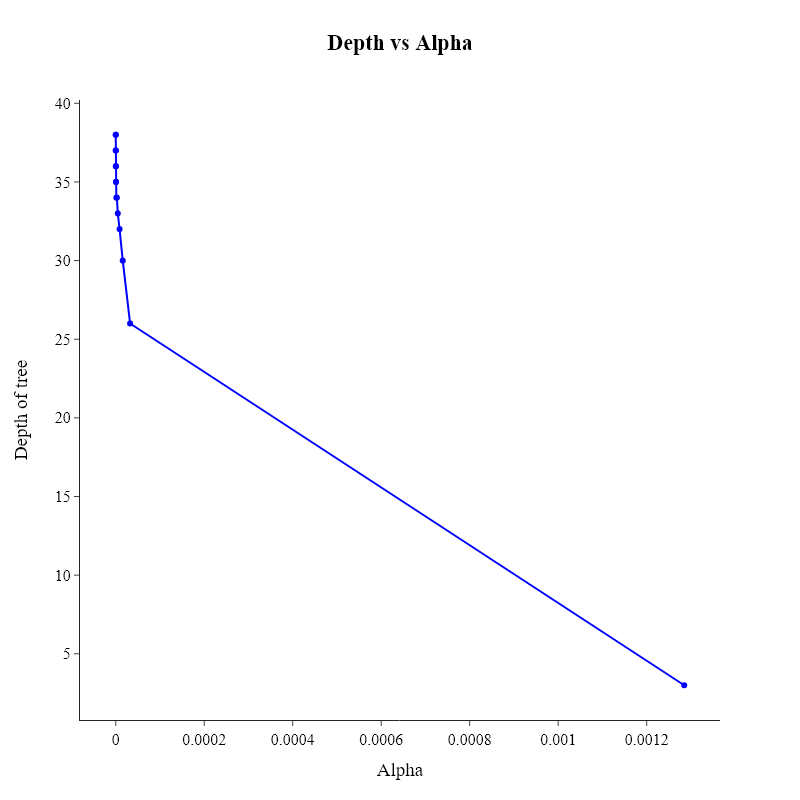

In [17]:
post_pruning.compare_depth_and_alpha(X=train_data[features], y=train_data[target])

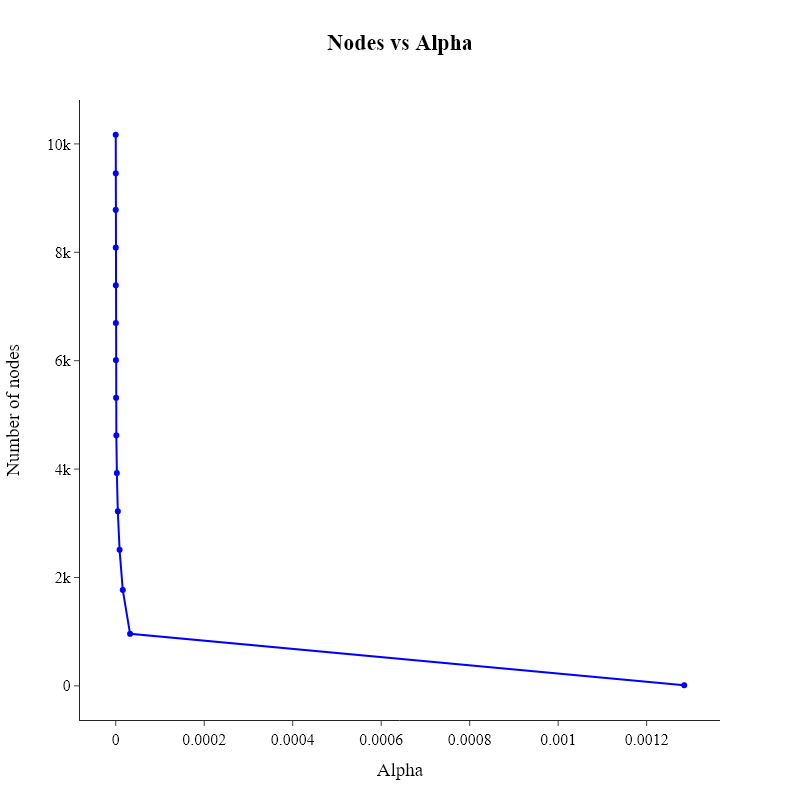

In [18]:
post_pruning.compare_nodes_and_alpha(X=train_data[features], y=train_data[target])

$\text{Wraz ze wzrostem wartości parametru alpha, zarówno głębokość drzewa jak i liczba liści maleje.}$<p>
$\text{Następnie przeanalizujemy wyniki na zbiorze treningowym i walidacyjnym w zależności od wartości parametru alpha.}$

ccp_alpha=0.0: train score: 0.0; valid score: 0.29438
ccp_alpha=0.0: train score: 0.0; valid score: 0.29438
ccp_alpha=0.0: train score: 0.00232; valid score: 0.29444
ccp_alpha=0.0: train score: 0.00405; valid score: 0.29443
ccp_alpha=0.0: train score: 0.00633; valid score: 0.29433
ccp_alpha=0.0: train score: 0.00888; valid score: 0.29422
ccp_alpha=0.0: train score: 0.01335; valid score: 0.29419
ccp_alpha=0.0: train score: 0.01761; valid score: 0.29403
ccp_alpha=0.0: train score: 0.02387; valid score: 0.2934
ccp_alpha=0.0: train score: 0.03374; valid score: 0.29205
ccp_alpha=0.0: train score: 0.04596; valid score: 0.28957
ccp_alpha=1e-05: train score: 0.06264; valid score: 0.287
ccp_alpha=2e-05: train score: 0.08496; valid score: 0.28202
ccp_alpha=3e-05: train score: 0.12175; valid score: 0.27003
ccp_alpha=0.00128: train score: 0.2495; valid score: 0.25186


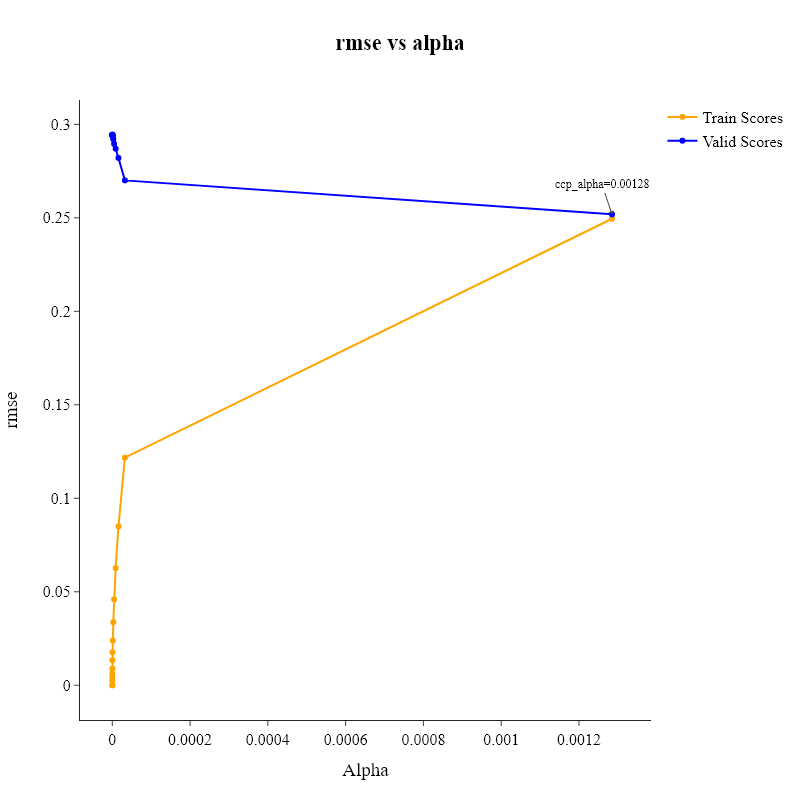

In [19]:
post_pruning.compare_scores_and_alpha(X=train_data[features], y=train_data[target], verbose=True)

$\text{Wraz ze wzrostem wartości parametru alpha, straty dla zbioru treningowego i walidacyjnego zbliżają się do siebie.}$<p>
$\text{Wartość parametru alpha=0.00127 wydaje się być optymalna.}$

# Podsumowanie

In [20]:
#Model bazowy
model = DecisionTreeRegressor(random_state=SEED)
base_train_scores, base_validation_scores = perform_cv(train_data[features], train_data[target], model)
base_test_score = test_evaluation(train_data[features], train_data[target], test_data[features], test_data[target], model)
#Pre-pruning
model = DecisionTreeRegressor(**best_params)
pre_pruning_train_scores, pre_pruning_validation_scores = perform_cv(train_data[features], train_data[target], model)
pre_pruning_test_score = test_evaluation(train_data[features], train_data[target], test_data[features], test_data[target], model)
#Post-pruning
best_alpha = 0.00127
model = DecisionTreeRegressor(ccp_alpha=best_alpha, random_state=SEED)
post_pruning_train_scores, post_pruning_validation_scores = perform_cv(train_data[features], train_data[target], model)
post_pruning_test_score = test_evaluation(train_data[features], train_data[target], test_data[features], test_data[target], model)
results = pd.DataFrame({
    "Model": ["Base", "Pre-pruning", "Post-pruning"],
    "Train RMSE": [base_train_scores, pre_pruning_train_scores, post_pruning_train_scores],
    "Validation RMSE": [base_validation_scores, pre_pruning_validation_scores, post_pruning_validation_scores],
    "Test RMSE": [base_test_score, pre_pruning_test_score, post_pruning_test_score]
})
results.style.background_gradient(cmap='Reds', axis=0)

,Model,Train RMSE,Validation RMSE,Test RMSE
0,Base,0.000000,0.294381,0.295259
1,Pre-pruning,0.218188,0.233232,0.240614
2,Post-pruning,0.249502,0.251859,0.246810


$\text{Dzięki zastosowanym technikom udało się zredukować overfitting modelu i poprawić wyniki zarówno na zbiorze walidacyjnym jak i testowym.}$<p>
$\text{Rezultaty okazały się najlepsze w przypadku modelu z optymalnymi hiperparametrami wybranymi podczas procesu pre prunningu.}$

In [21]:
print("Procentowa poprawa dla pre pruningu (względem modelu bazowego) na zbiorze testowym: {:.2f}%".format((base_test_score - pre_pruning_test_score) / base_test_score * 100))

Procentowa poprawa dla pre pruningu (względem modelu bazowego) na zbiorze testowym: 18.51%
